## Section 1: Import Dependencies.

In [1]:
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from transformers import DistilBertModel, DistilBertTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import jaccard_score, classification_report
import matplotlib.pyplot as plt

## Section 2: Define a function that will download a zip file from the given URL and extract its contents to the specified destination.

In [2]:
def download_and_extract_zip(url, zip_destination_file, extracted_destination):
    """
    Download a zip file from the given URL and extract its contents to the specified destination.

    Parameters:
    - url (str): The URL of the zip file.
    - zip_destination_file (str): The local path where the zip file should be saved.
    - extracted_destination (str): The directory where the contents of the zip file should be extracted.

    Returns:
    - None
    """

    # Check if the zip file is already downloaded
    if not os.path.exists(zip_destination_file):
        print(f'Downloading {url}...')
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        req = urllib.request.Request(url, headers=headers)
        with urllib.request.urlopen(req) as response, open(zip_destination_file, 'wb') as out_file:
            out_file.write(response.read())
        print(f'Download complete! Zip file saved at {zip_destination_file}')
    else:
        print(f'The zip file {zip_destination_file} already exists. Skipping download.')

    # Check if the contents are already extracted
    if not os.path.exists(extracted_destination):
        print(f'Extracting {zip_destination_file} to {extracted_destination}...')
        with zipfile.ZipFile(zip_destination_file, 'r') as zip_ref:
            zip_ref.extractall(extracted_destination)
        print(f'Extraction complete! Files saved at {extracted_destination}')
    else:
        print(f'The file/directory {extracted_destination} already exists. Skipping extraction.')

## Section 3: Download data using the previously defined function.

In [3]:
zip_url = 'http://saifmohammad.com/WebDocs/AIT-2018/AIT2018-DATA/SemEval2018-Task1-all-data.zip'
zip_destination_file = 'SemEval2018-Task1-all-data.zip'
extracted_destination = ''

download_and_extract_zip(zip_url, zip_destination_file, extracted_destination)

Download complete! Zip file saved at SemEval2018-Task1-all-data.zip
Extracting SemEval2018-Task1-all-data.zip to ...
Extraction complete! Files saved at 


## Section 4: Read Data into Pandas a DataFrame.

In [4]:
df = pd.read_csv('./SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-train.txt', sep='\t', on_bad_lines='skip')
df = df.drop(columns=['ID'])
df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6833,@nicky57672 Hi! We are working towards your hi...,0,0,0,0,0,0,0,0,0,0,0
6834,@andreamitchell said @berniesanders not only d...,0,1,0,0,0,0,0,0,0,1,0
6835,@isthataspider @dhodgs i will fight this guy! ...,1,0,1,0,0,0,0,1,0,0,0
6836,i wonder how a guy can broke his penis while h...,0,0,0,0,0,0,0,0,0,1,0


In [5]:
df_gold = pd.read_csv('./SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-test-gold.txt', sep='\t', on_bad_lines='skip')
df_gold = df_gold.drop(columns=['ID'])
df_gold

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,1,0,0,0,0,1,0,0,0,1
1,"Academy of Sciences, eschews the normally sobe...",0,0,1,0,0,0,0,0,0,0,0
2,I blew that opportunity -__- #mad,1,0,1,0,0,0,0,0,1,0,0
3,This time in 2 weeks I will be 30... 😥,0,0,0,0,1,0,0,0,1,0,0
4,#Deppression is real. Partners w/ #depressed p...,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,shaft abrasions from panties merely shifted to...,1,0,0,0,0,0,0,1,0,0,0
3255,@lomadia heard of Remothered? Indie horror gam...,0,1,0,0,0,0,0,1,0,0,0
3256,All this fake outrage. Y'all need to stop 🤣,1,0,1,0,0,0,0,0,0,0,0
3257,Would be ever so grateful if you could record ...,0,0,0,0,1,0,0,0,0,0,0


## Section 5: Load DistilBERT tokenizer and model

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Section 6: Tokenize and get the embedding vector for the [CLS] token

In [7]:
def get_cls_embedding(sentences):
  encoding = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
  output = model(**encoding)['last_hidden_state'][:, 0, :].detach().numpy()
  return output.reshape(-1)

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    embeddings_list = list(executor.map(get_cls_embedding, df['Tweet']))
    embeddings_list_gold = list(executor.map(get_cls_embedding, df_gold['Tweet']))

# Assign the embeddings to the DataFrame
X = np.vstack(embeddings_list)
X_gold = np.vstack(embeddings_list_gold)

In [8]:
Y = df.drop(columns=['Tweet']).to_numpy()
y_gold = df_gold.drop(columns=['Tweet']).to_numpy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()  # Assuming X_train is a feature matrix
X_test_tensor = torch.from_numpy(X_test).float()  # Assuming X_test is a feature matrix
y_train_tensor = torch.from_numpy(y_train).float()  # Assuming y_train is class indices
y_test_tensor = torch.from_numpy(y_test).float()  # Assuming y_test is class indices

X_gold_tensor = torch.from_numpy(X_gold).float()

In [10]:
class MultiLabelClassificationModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(MultiLabelClassificationModel, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out

In [11]:
# define the input and output sizes based on data
input_size = X.shape[1]
hidden_size = 50
num_classes = Y.shape[1]

# instantiate the model
model = MultiLabelClassificationModel(input_size, hidden_size, num_classes)

print(input_size)
print(num_classes)

768
11


In [12]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
num_epochs = 200

loss_history = []

for epoch in tqdm(range(num_epochs), desc='Training Progress'):

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

print('Training complete')

Training Progress: 100%|██████████| 200/200 [00:04<00:00, 43.95it/s]

Training complete


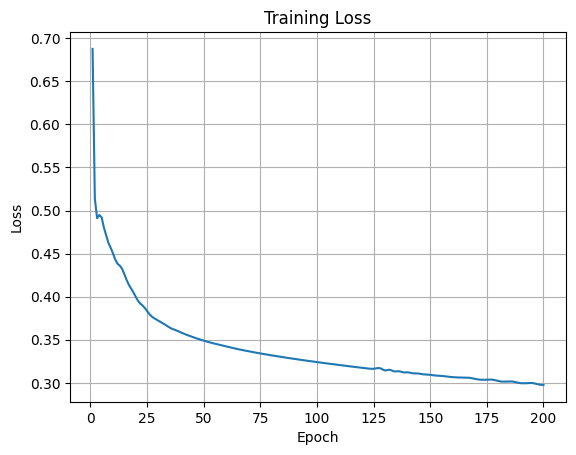

In [14]:
plt.plot(range(1, num_epochs + 1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

In [15]:
def MultiLabelAccuracy(pred_vals, real_vals):
    ML_accur = 0
    for row1, row2 in zip(pred_vals, real_vals):
        if len(row1) != len(row2):
            print("Rows are not the same length:")
            print(row1)
            print(row2)
        num_correct = 0
        num_labels = 0
        for i in range(len(row1)):
            if row1[i] == 1:
                num_labels += 1
            if row2[i] == 1:
                if row1[i] == row2[i]:
                    num_correct += 1
                else:
                    num_labels += 1


        intersection_size = num_correct
        # union_size = len(row1) + len(row2) - num_correct
        union_size = num_labels
        if intersection_size == 0 or union_size == 0:
            row_accur = 0
        else:
            row_accur = intersection_size / union_size
        ML_accur += row_accur
        # print(intersection_size)
        # print(union_size)
    # print(len(pred_vals))
    # print(ML_accur)
    return ML_accur / len(pred_vals)

In [16]:
model.eval()

num_correct = 0
num_samples = 0

with torch.no_grad():
  y_pred = model(X_test_tensor)
  nn_predicted = (y_pred > 0.5).float()
  predicted = (y_pred > 0.4).float()

  num_correct += (predicted == y_test_tensor).sum().item()
  num_samples += y_test_tensor.numel()

accuracy = num_correct / num_samples
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
MLA = MultiLabelAccuracy(nn_predicted, y_test_tensor)
print("Multi-label accuracy on test set: ", MLA)
jaccard1 = jaccard_score(y_test_tensor, nn_predicted, average="samples")
print(jaccard1)
y_pred

Accuracy on the test set: 84.30%
Multi-label accuracy on test set:  0.4550647451963238
0.4550647451963241


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tensor([[3.2959e-02, 6.8281e-02, 1.5118e-01,  ..., 9.8613e-01, 2.6996e-03,
         2.1718e-03],
        [8.9385e-01, 1.9484e-02, 7.4640e-01,  ..., 2.3624e-01, 7.3395e-03,
         6.8032e-03],
        [3.8598e-04, 9.1280e-02, 8.3274e-04,  ..., 7.4401e-03, 8.1185e-04,
         5.4896e-01],
        ...,
        [7.7958e-01, 9.2164e-02, 7.5564e-01,  ..., 4.0455e-01, 8.4643e-03,
         1.6447e-02],
        [2.5780e-01, 1.8428e-02, 4.5573e-01,  ..., 8.2822e-01, 2.8904e-03,
         2.2701e-03],
        [1.9742e-02, 3.6302e-02, 5.6581e-02,  ..., 9.1084e-01, 1.6505e-03,
         2.1446e-02]])

In [17]:
def ThresholdFineTuning(regr_pred):
    top_jaccard = [0,0]  # threshold, output value
    top_microF1 = [0,0]  # threshold, output value
    top_macroF1 = [0,0]  # threshold, output value

    cur_thresh = 0
    max_thresh = 1
    increment = 0.01

    pbar = tqdm(total=max_thresh)
    while cur_thresh <= max_thresh:
        temp_y_pred = np.copy(regr_pred)
        temp_y_pred[temp_y_pred > cur_thresh] = 1
        temp_y_pred[temp_y_pred <= cur_thresh] = 0

        temp_jaccard = jaccard_score(y_test, temp_y_pred, average="samples", zero_division=0)

        temp_report = classification_report(y_test, temp_y_pred, output_dict=True, zero_division=0)
        temp_micro = temp_report['micro avg']['f1-score']
        temp_macro = temp_report['macro avg']['f1-score']

        if temp_jaccard > top_jaccard[1]:
            top_jaccard = [cur_thresh, temp_jaccard]
        if temp_micro > top_microF1[1]:
            top_microF1 = [cur_thresh, temp_micro]
        if temp_macro > top_macroF1[1]:
            top_macroF1 = [cur_thresh, temp_macro]

        cur_thresh += increment
        pbar.update(increment)

    print()
    print(top_jaccard)
    print(top_microF1)
    print(top_macroF1)
    optimal_threshold = top_jaccard[0]
    return optimal_threshold

In [18]:
threshold = ThresholdFineTuning(y_pred)
print("Threshold: ", threshold)

 98%|█████████▊| 0.9800000000000006/1 [00:01<00:00,  1.53s/it]/usr/local/lib/python3.10/dist-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:01<00:00,  1.67s/it]


[0.2800000000000001, 0.5099310776942356]
[0.2800000000000001, 0.6362887729892945]
[0.21000000000000005, 0.5355569340157428]
Threshold:  0.2800000000000001


In [19]:
model.eval()

with torch.no_grad():
    y_pred_gold = model(X_gold_tensor)
    nn_predicted_2 = (y_pred_gold > 0.5).float()

nn_jaccard = jaccard_score(y_gold, nn_predicted_2, average="samples")
print(nn_jaccard)
nn_report = classification_report(y_gold, nn_predicted_2, output_dict=True)
print(classification_report(y_gold, nn_predicted_2))
y_pred_gold

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4833238358246029
              precision    recall  f1-score   support

           0       0.73      0.70      0.71      1101
           1       0.36      0.04      0.07       425
           2       0.71      0.68      0.69      1099
           3       0.68      0.44      0.54       485
           4       0.84      0.75      0.79      1442
           5       0.67      0.45      0.54       516
           6       0.72      0.57      0.64      1143
           7       0.51      0.10      0.17       375
           8       0.65      0.48      0.56       960
           9       0.40      0.01      0.02       170
          10       0.28      0.03      0.06       153

   micro avg       0.73      0.53      0.62      7869
   macro avg       0.60      0.39      0.43      7869
weighted avg       0.68      0.53      0.58      7869
 samples avg       0.65      0.55      0.57      7869



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tensor([[0.8578, 0.0516, 0.7100,  ..., 0.1668, 0.0040, 0.0167],
        [0.7470, 0.0261, 0.7767,  ..., 0.1201, 0.0118, 0.0126],
        [0.8061, 0.0450, 0.6728,  ..., 0.3501, 0.0244, 0.0060],
        ...,
        [0.9546, 0.2129, 0.7690,  ..., 0.2146, 0.0058, 0.0222],
        [0.0310, 0.1905, 0.0577,  ..., 0.0940, 0.1009, 0.1219],
        [0.5827, 0.1596, 0.6361,  ..., 0.0733, 0.0648, 0.0443]])

In [20]:
nn_pred_gold = y_pred_gold[:]
nn_pred_gold[nn_pred_gold > threshold] = 1
nn_pred_gold[nn_pred_gold <= threshold] = 0

nn_jaccard = jaccard_score(y_gold, nn_pred_gold, average="samples")
print(nn_jaccard)
nn_report = classification_report(y_gold, nn_pred_gold, output_dict=True)
print(classification_report(y_gold, nn_pred_gold))

0.5218807989596576
              precision    recall  f1-score   support

           0       0.63      0.83      0.72      1101
           1       0.33      0.27      0.29       425
           2       0.60      0.85      0.70      1099
           3       0.51      0.61      0.55       485
           4       0.75      0.86      0.80      1442
           5       0.54      0.64      0.59       516
           6       0.63      0.77      0.70      1143
           7       0.34      0.26      0.29       375
           8       0.53      0.75      0.62       960
           9       0.30      0.10      0.15       170
          10       0.18      0.10      0.13       153

   micro avg       0.59      0.71      0.64      7869
   macro avg       0.48      0.55      0.50      7869
weighted avg       0.58      0.71      0.63      7869
 samples avg       0.61      0.72      0.63      7869



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344

In [21]:
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight="balanced_subsample", random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [24]:
rf_y_pred = rf_classifier.predict(X_test)
rf_MLA = MultiLabelAccuracy(rf_y_pred, y_test)
print(rf_MLA)
rf_class_report = classification_report(y_test, rf_y_pred, output_dict=True)
print("Classification Report for Random Forest (Test Set): \n", classification_report(y_test, rf_y_pred))

0.17524366471734892
Classification Report for Random Forest (Test Set): 
               precision    recall  f1-score   support

           0       0.85      0.30      0.44       507
           1       0.50      0.01      0.01       200
           2       0.77      0.29      0.42       516
           3       1.00      0.01      0.02       283
           4       0.88      0.37      0.52       507
           5       0.00      0.00      0.00       136
           6       0.83      0.20      0.32       400
           7       0.00      0.00      0.00       166
           8       0.70      0.04      0.08       424
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        71

   micro avg       0.83      0.18      0.30      3286
   macro avg       0.50      0.11      0.17      3286
weighted avg       0.70      0.18      0.27      3286
 samples avg       0.29      0.18      0.21      3286



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [64]:
rf_y_pred_gold = rf_classifier.predict(X_gold)
rf_MLA_gold = MultiLabelAccuracy(rf_y_pred_gold, y_gold)
print(rf_MLA_gold)
rf_class_report_gold = classification_report(y_gold, rf_y_pred_gold, output_dict=True)
print("Classification Report for Random Forest (Test Set): \n", classification_report(y_gold, rf_y_pred_gold))

0.16762299273805828
Classification Report for Random Forest (Test Set): 
               precision    recall  f1-score   support

           0       0.81      0.23      0.36      1101
           1       0.00      0.00      0.00       425
           2       0.78      0.24      0.37      1099
           3       0.00      0.00      0.00       485
           4       0.89      0.41      0.56      1442
           5       1.00      0.00      0.00       516
           6       0.81      0.16      0.27      1143
           7       0.00      0.00      0.00       375
           8       0.76      0.01      0.03       960
           9       0.00      0.00      0.00       170
          10       0.00      0.00      0.00       153

   micro avg       0.84      0.17      0.28      7869
   macro avg       0.46      0.10      0.14      7869
weighted avg       0.66      0.17      0.25      7869
 samples avg       0.29      0.17      0.21      7869



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [25]:
rf_regressor = RandomForestRegressor(random_state=42)

rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
rf_y_pred = rf_regressor.predict(X_test)
rf_threshold = .5
rf_regr_pred = np.copy(rf_y_pred)
rf_regr_pred[rf_regr_pred > rf_threshold] = 1
rf_regr_pred[rf_regr_pred <= rf_threshold] = 0

print("Jaccard: ", jaccard_score(y_test, rf_regr_pred, average="samples"))
print(classification_report(y_test, rf_regr_pred))
rf_y_pred

Jaccard:  0.27130847953216375
              precision    recall  f1-score   support

           0       0.79      0.49      0.60       507
           1       0.50      0.01      0.02       200
           2       0.71      0.46      0.56       516
           3       0.79      0.05      0.10       283
           4       0.83      0.51      0.63       507
           5       0.75      0.04      0.08       136
           6       0.76      0.35      0.48       400
           7       0.00      0.00      0.00       166
           8       0.73      0.12      0.20       424
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        71

   micro avg       0.77      0.29      0.42      3286
   macro avg       0.53      0.18      0.24      3286
weighted avg       0.68      0.29      0.38      3286
 samples avg       0.42      0.29      0.32      3286



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification

array([[0.14, 0.16, 0.14, ..., 0.73, 0.04, 0.02],
       [0.72, 0.08, 0.74, ..., 0.27, 0.09, 0.02],
       [0.06, 0.11, 0.05, ..., 0.07, 0.  , 0.1 ],
       ...,
       [0.65, 0.15, 0.6 , ..., 0.33, 0.03, 0.02],
       [0.4 , 0.16, 0.38, ..., 0.42, 0.02, 0.04],
       [0.19, 0.13, 0.21, ..., 0.55, 0.02, 0.09]])

In [29]:
rf_regr_thresh = ThresholdFineTuning(rf_y_pred)
print(rf_regr_thresh)
rf_regr_pred = rf_regressor.predict(X_gold)
rf_regr_pred_gold = rf_regr_pred[:]
rf_regr_pred_gold[rf_regr_pred > rf_regr_thresh] = 1
rf_regr_pred_gold[rf_regr_pred <= rf_regr_thresh] = 0
rf_regr_pred_gold

rf_regr_MLA = MultiLabelAccuracy(rf_regr_pred_gold, y_gold)
rf_regr_jacccard = jaccard_score(y_gold, rf_regr_pred_gold, average="samples")
rf_regr_report = classification_report(y_gold, rf_regr_pred_gold, output_dict=True)
print("MLA: ", rf_regr_MLA)
print("Jaccard: ", rf_regr_jacccard)
print(classification_report(y_gold, rf_regr_pred_gold))

 96%|█████████▌| 0.9600000000000006/1 [00:04<00:00,  2.52s/it]/usr/local/lib/python3.10/dist-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:04<00:00,  4.47s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[0.3100000000000001, 0.4657555346700084]
[0.3200000000000001, 0.5830191524656915]
[0.17, 0.42526595092339325]
0.3100000000000001
MLA:  0.47866238548196566
Jaccard:  0.47866238548196205
              precision    recall  f1-score   support

           0       0.58      0.81      0.67      1101
           1       0.00      0.00      0.00       425
           2       0.55      0.84      0.66      1099
           3       0.60      0.21      0.31       485
           4       0.65      0.88      0.75      1442
           5       0.65      0.33      0.44       516
           6       0.58      0.75      0.66      1143
           7       0.32      0.02      0.03       375
           8       0.46      0.62      0.53       960
           9       0.00      0.00      0.00       170
          10       0.67      0.03      0.05       153

   micro avg       0.57      0.61      0.59      7869
   macro avg       0.46      0.41      0.37      7869
weighted avg       0.52      0.61      0.53      7869
 s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [30]:
svr_regressor = SVR(verbose=True)
multi_svr = MultiOutputRegressor(svr_regressor)
multi_svr.fit(X_train, y_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

MultiOutputRegressor(estimator=SVR(verbose=True))

In [32]:
multi_svr_y_pred = multi_svr.predict(X_test)
multi_svr_thresh = ThresholdFineTuning(multi_svr_y_pred)
print("Optimal Threshold: ", multi_svr_thresh)

 99%|█████████▉| 0.9900000000000007/1 [00:01<00:00,  1.45s/it]/usr/local/lib/python3.10/dist-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:01<00:00,  1.62s/it]


[0.21000000000000005, 0.5025193191311612]
[0.19000000000000003, 0.6235409928280129]
[0.10999999999999999, 0.48418152184630503]
Optimal Threshold:  0.21000000000000005


In [34]:
multi_svr_pred = multi_svr.predict(X_gold)
multi_svr_pred_gold = multi_svr_pred[:]
multi_svr_pred_gold[multi_svr_pred_gold > multi_svr_thresh] = 1
multi_svr_pred_gold[multi_svr_pred_gold <= multi_svr_thresh] = 0

multi_svr_MLA = MultiLabelAccuracy(multi_svr_pred_gold, y_gold)
multi_svr_jaccard = jaccard_score(y_gold, multi_svr_pred_gold, average="samples")
multi_svr_report = classification_report(y_gold, multi_svr_pred_gold, output_dict=True)
print("MLA: ", multi_svr_MLA)
print("Jaccard: ", multi_svr_jaccard)
print(classification_report(y_gold, multi_svr_pred_gold))

MLA:  0.5168843787898759
Jaccard:  0.5168843787898713
              precision    recall  f1-score   support

           0       0.59      0.88      0.71      1101
           1       0.00      0.00      0.00       425
           2       0.58      0.88      0.70      1099
           3       0.62      0.48      0.54       485
           4       0.68      0.92      0.78      1442
           5       0.72      0.32      0.44       516
           6       0.62      0.79      0.69      1143
           7       0.00      0.00      0.00       375
           8       0.57      0.64      0.60       960
           9       0.00      0.00      0.00       170
          10       0.00      0.00      0.00       153

   micro avg       0.62      0.66      0.64      7869
   macro avg       0.40      0.45      0.41      7869
weighted avg       0.53      0.66      0.58      7869
 samples avg       0.64      0.67      0.62      7869



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification

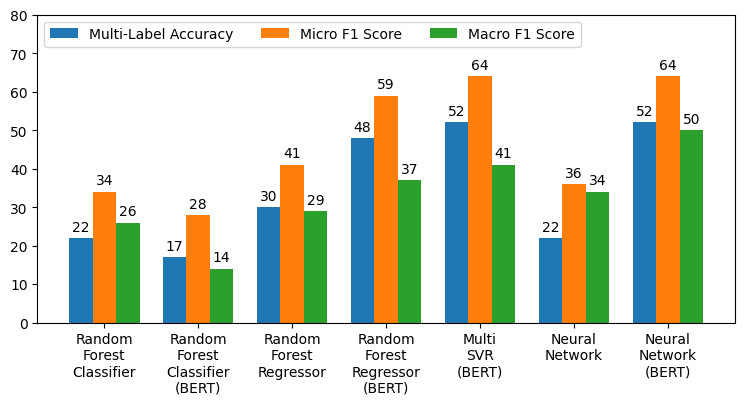

In [65]:
models = [ "Random\nForest\nClassifier", "Random\nForest\nClassifier\n(BERT)", "Random\nForest\nRegressor", "Random\nForest\nRegressor\n(BERT)", "Multi\nSVR\n(BERT)", "Neural\nNetwork", "Neural\nNetwork\n(BERT)"]

# Data from non-BERT encoder is manually input from other file
graph_data = {
    'Multi-Label Accuracy': (0.22, round(rf_MLA_gold, 2), 0.30, round(rf_regr_jacccard, 2), round(multi_svr_jaccard, 2), .22, round(nn_jaccard, 2)),
    'Micro F1 Score':(0.34,
                      round(rf_class_report_gold['micro avg']['f1-score'], 2),
                      0.41,
                      round(rf_regr_report['micro avg']['f1-score'], 2),
                      round(multi_svr_report['micro avg']['f1-score'], 2),
                      0.36,
                      round(nn_report['micro avg']['f1-score'], 2),
                      ),
    'Macro F1 Score': (0.26,
                       round(rf_class_report_gold['macro avg']['f1-score'], 2),
                       0.29,
                       round(rf_regr_report['macro avg']['f1-score'], 2),
                       round(multi_svr_report['macro avg']['f1-score'], 2),
                       0.34,
                       round(nn_report['macro avg']['f1-score'], 2),
                       ),
}

# scales data
graph_data = {key: tuple(val * 100 for val in values) for key, values in graph_data.items()}

fig, ax = plt.subplots(figsize=[9, 4])

x = np.arange(len(models))
width = .25
multiplier = 0

for attribute, measurement in graph_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 80)

plt.show()